# Restricted Boltzmann Machines

For a detailed presentation, refer to the section '**1.4 Boltzmann Machines**' in the file *MachineLearningOverview.pdf*, which is included in the same repository as this notebook.

A restricted Boltzmann machine (RBM) is a generative stochastic artificial neural network that can be used for unsupervised learning tasks, such as dimensionality reduction, feature learning, collaborative filtering and topic modeling. RBMs are particularly useful for modeling complex distributions of high-dimensional data, such as images, speech signals, and genomic data and have been successfully applied in a wide range of fields, including computer vision, speech recognition, natural language processing and bioinformatics. RBMs are also used as building blocks for more complex deep learning models, such as deep belief networks and deep autoencoders, which are used for tasks like image and text generation and anomaly detection. They can extract features of some dataset and the output can be used in a supervised model like linear regression or support vector machines for classification.

A RBM with 3 visible units and 7 hidden units is presented below:

<img src="./images/rbm.drawio.png" width="60%" align="center">

We will use the *Fashion-MNIST dataset* in order to train a RBM to generate synthetic data that resembles the samples of this dataset. The Fashion-MNIST dataset is a benchmark dataset commonly used in the field of computer vision for image classification tasks. It was created as a more challenging alternative to the popular MNIST dataset, which consists of grayscale images of handwritten digits. It consists of 70,000 grayscale images of size 28x28 pixels, which are divided into 60,000 training images and 10,000 testing images. Each image in the dataset belongs to one of 10 different classes representing different types of clothing and accessories, including T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags and ankle boots.

The code is implemented as per *Geoffrey's Hinton* practical guide to training RBMs, *A Practical Guide to Training Restricted Boltzmann Machines Version 1*, *Department of Computer Science, University of Toronto*, August 2, 2010, UTML TR 2010–003: https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf

This is a practical guide for tuning RBMs and we just use some of the advice given. Training a RBM is a complex procedure and one should experiment with many variations and heuristics in order to achieve the desired result.

First, let us import the necessary packages and load the Fashion-MNIST dataset.

In [1]:
# hide tensorflow warnings on GPU execution (we will use CPU)
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow import keras
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt
import numpy as np
import time

# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Print the shape of the training data
print('Training data shape:', x_train.shape, y_train.shape)

# Print the shape of the testing data
print('Testing data shape:', x_test.shape, y_test.shape)

Training data shape: (60000, 28, 28) (60000,)
Testing data shape: (10000, 28, 28) (10000,)


Let us display some random samples from the dataset:

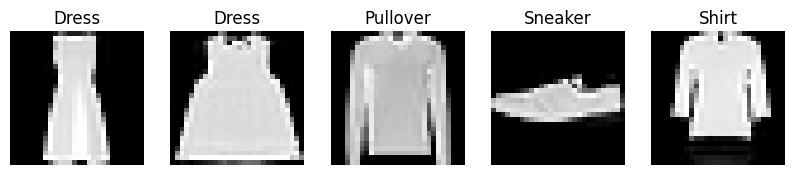

In [2]:
# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Generate a random sample of images to display
num_images = 5
rand_idx = np.random.randint(x_train.shape[0], size=num_images)

# Display the images and their labels
fig, axes = plt.subplots(1, num_images, figsize=(10,10))
for i, ax in enumerate(axes):
    ax.imshow(x_train[rand_idx[i]], cmap='gray')
    ax.set_title(class_labels[y_train[rand_idx[i]]])
    ax.axis('off')

plt.show()

Then, we reshape the data into arrays and move to normalization (pre-processing) and definition of the RBM hyperparameters.

In [3]:
training_data = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
test_data = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

# Print the shape of the reshaped training data
print('Reshaped training data shape:', training_data.shape)

# Print the shape of the reshaped testing data
print('Reshaped testing data shape:', test_data.shape)

Reshaped training data shape: (60000, 784)
Reshaped testing data shape: (10000, 784)


In [4]:
# normalize
threshold = 128
training_data = (training_data > np.ones(training_data.shape)*threshold)*1
test_data = (test_data > np.ones(test_data.shape)*threshold)*1

# define model hyperparameters
num_visible = training_data.shape[1]  # number of visible units corresponds to number of features
num_hidden = 100  # number of hidden units is set to 100 (sufficient)

# define training parameters
epochs = 20
# for datasets containing small number of equiprobable classes, 
# the ideal mini-batch size for contrastive divergence equals to the number of classes
batch_size = 10
# learning rate
eta = 0.0125

# store reconstruction error for different hyperparameters (for monitoring purposes)
rec_err = np.zeros(epochs)

Now, we define the RBM class that implements the model that we will train:

In [5]:
class RBM(object):
    # class constructor
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        
        # initialize randomly the biases with a Gaussian of mean 0 and standard deviation 1
        self.visible_bias = np.random.normal(loc=0, scale=1, size=(1, num_visible))
        self.hidden_bias = np.random.normal(loc=0, scale=1, size=(1, num_hidden))
        
        # initialize the weight matrix with a Gaussian of mean 0 and standard deviation 0.01
        self.weights = np.random.normal(loc=0, scale=0.01, size=(num_visible, num_hidden))
        
        # the following parameters are used to implement momentum in training as Hinton suggests
        self.w_inc = np.zeros(self.weights.shape)
        self.a_inc = np.zeros(self.visible_bias.shape)
        self.b_inc = np.zeros(self.hidden_bias.shape)
        
    # Positive phase of contrastive divergence (CD) -- data driven phase
    # Sample the states of hidden units based on p_hidden_given_visible
    def sample_hidden_given_visible(self, visible_data):
        z_hidden = np.dot(visible_data, self.weights) + self.hidden_bias
        p_hidden_given_visible = self.sigmoid(z_hidden)
        hidden_sample = p_hidden_given_visible > np.random.rand(visible_data.shape[0], self.num_hidden)
        # return the probabilities as well, needed for the positive phase of the gradients (data phase)
        # less sampling noise --> faster learning
        # sampled hidden states are also needed to reconstruct the visible states in the negative phase of CD
        return p_hidden_given_visible, hidden_sample
    
    # Negative phase of CD -- reconstruction driven phase
    # Here, do not sample the visible units but use the probabilities instead to avoid sampling noise
    def sample_visible_given_hidden(self, hidden_sample):
        z_visible = np.dot(hidden_sample, self.weights.T) + self.visible_bias
        p_visible_given_hidden = self.sigmoid(z_visible)
        return p_visible_given_hidden
    
    # Sample the hidden states given the visible states (data), then
    # get the visible states (reconstructed from hidden samples) as probabilities without sampling
    # and at the last update get the hidden states (reconstructed from visible) as probabilities without sampling
    def gibbs_sampling(self, visible):
        hidden_prob, hidden_sample = self.sample_hidden_given_visible(visible)
        visible_recon = self.sample_visible_given_hidden(hidden_sample)
        z_hidden_recon_last = np.dot(visible_recon, self.weights) + self.hidden_bias
        hidden_recon_last = self.sigmoid(z_hidden_recon_last)
        # return reconstructed visible states (probabilities), needed for the negative phase of the gradients
        # return hidden probabilities, needed for the positive phase of the gradients
        # return last update of hidden units, needed for the negative phase of the gradients
        return visible_recon, hidden_prob, hidden_recon_last
    
    # training the RBM with mini-batches
    def train_RBM(self, training_data, epochs, batch_size, eta):
        # the goal of the model is to generate synthetic data
        # the model is trained using the Contrastive Divergence (CD) algorithm as per Hinton
        for epoch in range(epochs):
            # partition the dataset in mini-batches, each of size [batch_size]
            data_size = len(training_data)
            mini_batches = [training_data[i:i+batch_size] for i in range(0, data_size, batch_size)]
            # monitor the reconstruction error
            error = 0
            for batch in mini_batches:
                # perform one step of contrastive divergence (sufficient in practice as per Hinton)
                visible_recon, hidden_prob, hidden_recon_last = self.gibbs_sampling(batch)
                # update the parameters
                self.update_CD(batch, visible_recon, hidden_prob, hidden_recon_last, batch_size, eta, epoch)
                error += np.sum((batch-visible_recon)**2)/batch_size
                
            error = error/(data_size/batch_size)
            rec_err[epoch] = error
            print('Epoch %s completed. Reconstruction error is %0.2f' % (epoch+1, error))
        print('\nTraining completed.')
        
        return rec_err
        
    # update the parameters to maximize the log-likelihood and minimize the reconstruction error
    def update_CD(self, batch, visible_recon, hidden_prob, hidden_recon_last, batch_size, eta, epoch):
        # compute the gradients for the weights and biases
        dw = (np.dot(batch.T, hidden_prob) - np.dot(visible_recon.T, hidden_recon_last))/batch_size
        dvb = (np.sum(batch, axis=0) - np.sum(visible_recon, axis=0))/batch_size
        dhb = (np.sum(hidden_prob, axis=0) - np.sum(hidden_recon_last, axis=0))/batch_size
        
        # set momentum and decrease learning rate at the end of training as per Hinton's practical guide
        m = 0.5 if epoch < 5 else 0.9
        eta = eta/batch_size if epoch > 15 else eta
        
        # introduce momentum in the update rules
        self.w_inc = self.w_inc*m + eta*dw
        self.a_inc = self.a_inc*m + eta*dvb
        self.b_inc = self.b_inc*m + eta*dhb
        
        # update the parameters
        self.weights += self.w_inc
        self.visible_bias += self.a_inc
        self.hidden_bias += self.b_inc
        
    # reconstruct the input vector
    def Reconstruct(self, visible, recon_steps):
        
        V_rec = np.copy(visible)
        
        for i in range(recon_steps):
            p_hidden_given_visible = self.sample_hidden_given_visible(visible)[0]
            # sample
            hidden_sample = p_hidden_given_visible > np.random.rand(1, self.num_hidden)
            V_rec = self.sample_visible_given_hidden(hidden_sample)
            
        return V_rec
        
    
    # the sigmoid function
    def sigmoid(self, z):
        sig =  1.0/(1.0 + np.exp(-z))
        return sig

At last, we are ready to train the RBM.

In [6]:
rbm = RBM(num_visible, num_hidden)

start_time = time.time()
rbm.train_RBM(training_data, epochs, batch_size, eta)
exec_time = time.time() - start_time
print(f"Training time for {epochs} epochs, {num_hidden} hidden units and learning rate of {eta} :--- {exec_time} seconds ---")

Epoch 1 completed. Reconstruction error is 58.59
Epoch 2 completed. Reconstruction error is 42.97
Epoch 3 completed. Reconstruction error is 39.36
Epoch 4 completed. Reconstruction error is 37.74
Epoch 5 completed. Reconstruction error is 36.86
Epoch 6 completed. Reconstruction error is 37.05
Epoch 7 completed. Reconstruction error is 36.07
Epoch 8 completed. Reconstruction error is 35.70
Epoch 9 completed. Reconstruction error is 35.41
Epoch 10 completed. Reconstruction error is 35.15
Epoch 11 completed. Reconstruction error is 34.95
Epoch 12 completed. Reconstruction error is 34.83
Epoch 13 completed. Reconstruction error is 34.78
Epoch 14 completed. Reconstruction error is 34.69
Epoch 15 completed. Reconstruction error is 34.62
Epoch 16 completed. Reconstruction error is 34.54
Epoch 17 completed. Reconstruction error is 33.21
Epoch 18 completed. Reconstruction error is 33.07
Epoch 19 completed. Reconstruction error is 33.02
Epoch 20 completed. Reconstruction error is 33.01

Training

We should note here that reconstruction error is not representative, but we want to keep track on the training process in terms of convergence. In summary, to count the error and track the training process of an RBM that uses the Contrastive Divergence algorithm, we need to compute the reconstruction error of the model after each training iteration and monitor the trend of the error over time.

### Generate synthetic data with the RBM

Now, we will use the RBM to generate synthetic data given samples from the test dataset.

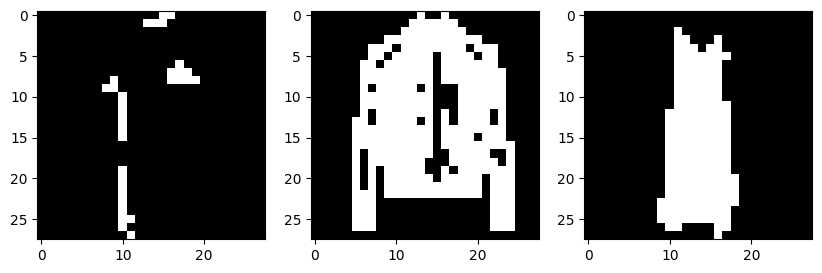

In [7]:
# choose 3 random samples from test dataset
sample_1 = test_data[np.random.randint(0, len(test_data)-1)]
sample_2 = test_data[np.random.randint(0, len(test_data)-1)]
sample_3 = test_data[np.random.randint(0, len(test_data)-1)]
# reshape
im_1 = np.reshape(sample_1, (28, 28))
im_2 = np.reshape(sample_2, (28, 28))
im_3 = np.reshape(sample_3, (28, 28))
# display
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(im_1, cmap='gray')
ax[1].imshow(im_2, cmap='gray')
ax[2].imshow(im_3, cmap='gray')
plt.show()

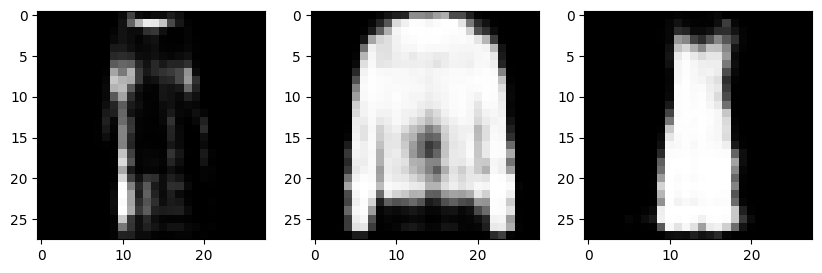

In [8]:
# reconstruct the images with the RBM
rbm_sample_1 = rbm.Reconstruct(sample_1, 5)
rbm_sample_2 = rbm.Reconstruct(sample_2, 5)
rbm_sample_3 = rbm.Reconstruct(sample_3, 5)

# reshape and display
rbm_im_1 = np.reshape(rbm_sample_1, (28, 28))
rbm_im_2 = np.reshape(rbm_sample_2, (28, 28))
rbm_im_3 = np.reshape(rbm_sample_3, (28, 28))
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(rbm_im_1, cmap='gray')
ax[1].imshow(rbm_im_2, cmap='gray')
ax[2].imshow(rbm_im_3, cmap='gray')
plt.show()

One advantage of using RBMs for synthetic data generation is that they can learn a compressed representation of the input data, which can help to reduce the dimensionality of the data and remove noisy or irrelevant features. This can be particularly useful for applications such as image generation, where the high-dimensional nature of the input data can make it difficult to generate high-quality synthetic images. However, it is important to keep in mind that RBMs are just one of many possible approaches for synthetic data generation and their effectiveness will depend on the specific characteristics of the input data and the requirements of the application. It may be useful to experiment with different generative models and techniques to find the best approach for some particular use case.

### Monitor the Reconstruction Error for different hyperparameters

Epoch 1 completed. Reconstruction error is 45.51
Epoch 2 completed. Reconstruction error is 38.67
Epoch 3 completed. Reconstruction error is 37.72
Epoch 4 completed. Reconstruction error is 37.21
Epoch 5 completed. Reconstruction error is 36.78
Epoch 6 completed. Reconstruction error is 47.87


/tmp/ipykernel_33337/2605302928.py:111: RuntimeWarning: overflow encountered in exp
  sig =  1.0/(1.0 + np.exp(-z))


Epoch 7 completed. Reconstruction error is 47.63
Epoch 8 completed. Reconstruction error is 47.36
Epoch 9 completed. Reconstruction error is 46.79
Epoch 10 completed. Reconstruction error is 46.77
Epoch 11 completed. Reconstruction error is 46.74
Epoch 12 completed. Reconstruction error is 46.47
Epoch 13 completed. Reconstruction error is 46.49
Epoch 14 completed. Reconstruction error is 46.52
Epoch 15 completed. Reconstruction error is 46.21
Epoch 16 completed. Reconstruction error is 46.15
Epoch 17 completed. Reconstruction error is 40.36
Epoch 18 completed. Reconstruction error is 39.16
Epoch 19 completed. Reconstruction error is 38.81
Epoch 20 completed. Reconstruction error is 38.67

Training completed.
Training time for 20 epochs, 100 hidden units and learning rate of 0.1 :--- 295.48187375068665 seconds ---

Epoch 1 completed. Reconstruction error is 48.81
Epoch 2 completed. Reconstruction error is 38.46
Epoch 3 completed. Reconstruction error is 37.18
Epoch 4 completed. Reconstr

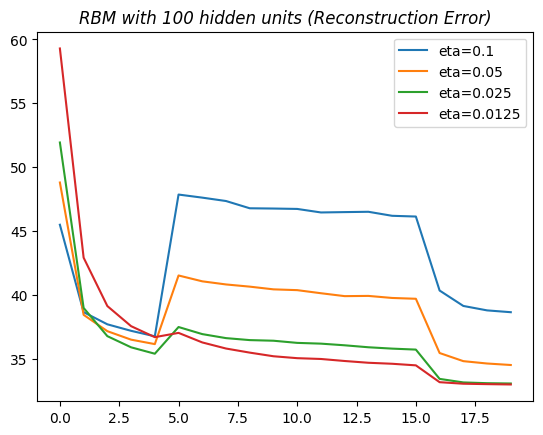

In [9]:
# 100 hidden units
eta = [0.1, 0.05, 0.025, 0.0125]
error_all = np.zeros((len(eta),epochs))  # 4 tests of 20 epochs each

i = 0
for lr in eta:
        rbm = RBM(784, 100)
        start_time = time.time()
        error_all[i] = rbm.train_RBM(training_data, epochs, batch_size, lr)
        exec_time = time.time() - start_time
        print(f"Training time for 20 epochs, 100 hidden units and learning rate of {lr} :--- {exec_time} seconds ---")
        print()
        plt.plot(error_all[i])
        i += 1
        
plt.title("RBM with 100 hidden units (Reconstruction Error)", style='italic')
plt.legend(['eta=0.1', 'eta=0.05', 'eta=0.025', 'eta=0.0125'])
plt.show()

As we can see, due to momentum in training, the reconstruction error faces a spike after the 5th epoch. This effect is reduced by decreasing the learning rate by a factor of 2. Also, the decrease of the learning rate at the end of training (after 15 epochs) follows a decrease in error as well.

Epoch 1 completed. Reconstruction error is 38.32
Epoch 2 completed. Reconstruction error is 31.39
Epoch 3 completed. Reconstruction error is 30.37
Epoch 4 completed. Reconstruction error is 29.85
Epoch 5 completed. Reconstruction error is 29.58


/tmp/ipykernel_33337/2605302928.py:111: RuntimeWarning: overflow encountered in exp
  sig =  1.0/(1.0 + np.exp(-z))


Epoch 6 completed. Reconstruction error is 46.94
Epoch 7 completed. Reconstruction error is 46.04
Epoch 8 completed. Reconstruction error is 45.21
Epoch 9 completed. Reconstruction error is 44.81
Epoch 10 completed. Reconstruction error is 44.21
Epoch 11 completed. Reconstruction error is 43.94
Epoch 12 completed. Reconstruction error is 43.83
Epoch 13 completed. Reconstruction error is 43.69
Epoch 14 completed. Reconstruction error is 43.38
Epoch 15 completed. Reconstruction error is 43.57
Epoch 16 completed. Reconstruction error is 43.49
Epoch 17 completed. Reconstruction error is 36.83
Epoch 18 completed. Reconstruction error is 34.68
Epoch 19 completed. Reconstruction error is 33.78
Epoch 20 completed. Reconstruction error is 33.22

Training completed.
Training time for 20 epochs, 200 hidden units and learning rate of 0.1 :--- 539.7165448665619 seconds ---

Epoch 1 completed. Reconstruction error is 39.96
Epoch 2 completed. Reconstruction error is 30.05
Epoch 3 completed. Reconstru

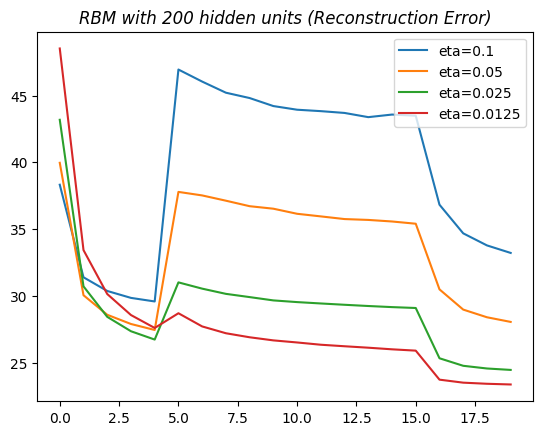

In [10]:
# 200 hidden units
eta = [0.1, 0.05, 0.025, 0.0125]
error_all = np.zeros((len(eta),epochs))  # 4 tests of 20 epochs each

i = 0
for lr in eta:
        rbm = RBM(784, 200)
        start_time = time.time()
        error_all[i] = rbm.train_RBM(training_data, epochs, batch_size, lr)
        exec_time = time.time() - start_time
        print(f"Training time for 20 epochs, 200 hidden units and learning rate of {lr} :--- {exec_time} seconds ---")
        print()
        plt.plot(error_all[i])
        i += 1
        
plt.title("RBM with 200 hidden units (Reconstruction Error)", style='italic')
plt.legend(['eta=0.1', 'eta=0.05', 'eta=0.025', 'eta=0.0125'])
plt.show()

### Differences between MNIST and Fashion-MNIST

One key difference between MNIST and Fashion-MNIST is the complexity of the classification task. While MNIST consists of simple, uniform images of handwritten digits, Fashion-MNIST includes more diverse and complex images of clothing and accessories, with variations in texture, shape, and style. This makes the task of classifying the images in Fashion-MNIST more challenging than the task in MNIST.

Another difference between the two datasets is their relevance to real-world applications. MNIST has been used for decades as a standard benchmark for image classification tasks, but its practical applications are limited. Fashion-MNIST, on the other hand, was designed to be a more realistic and challenging dataset that better reflects the types of images encountered in real-world computer vision applications, such as e-commerce and fashion recommendation systems.